# PySINDy: A Python package for the sparse identification of nonlinear dynamical systems from data
Brian de Silva

* Code: https://github.com/dynamicslab/pysindy
* Documentation: https://pysindy.readthedocs.io/en/latest/index.html

## Topics
* What is the sparse identification of nonlinear dynamics (SINDy) method?
* How to use PySINDy to learn governing equations from measurement data
* Structure of PySINDy
* PySINDy advanced features


## Motivating example
Suppose I have conducted an experiment where I observed the motion of a particle starting from a particular position in space. Say I recorded the position of the particle every $0.01$ seconds for $10$ seconds and now I would like to use my measurements to form a model that will let me predict the particle's motion starting from a different point in space.

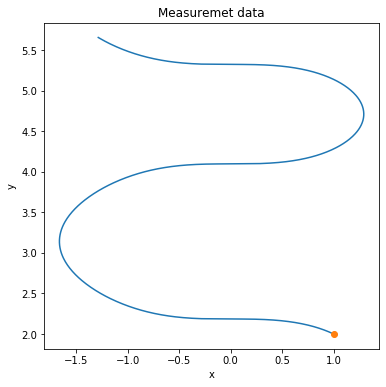

In [1]:
import matplotlib.pyplot as plt
import numpy as np

x = np.load('data.npy')

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(x[:, 0], x[:, 1])
ax.plot(x[0, 0], x[0, 1], 'o')
ax.set(xlabel='x', ylabel='y', title='Measuremet data')

fig.show()

## Sparse identification of nonlinear dynamics (SINDy) primer

SINDy gives me a way to translate my measurement data into a plausible dynamical system governing the time-evolution of the particle system.

We attempt to represent the time evolution of $x(t)$ in terms of a nonlinear function $f$:

$$ \frac{d}{dt}x(t) = f(x(t)). $$

Often, the components of $f$ are *sparse* in the space of possible functions. If we pick the right basis they can be written as a linear combination of basis functions with most coefficients equal to 0:

$$ f_i(x) = \xi_1\theta_1(x) + \xi_2\theta_2(x) + \dots + \xi_k\theta_k(x) $$

### The algorithm

**1.** Stack the measurements and their derivatives into matrices $X$ and $\dot{X}$ (PySINDy can form $\dot{X}$ for us):

$$
	X = \begin{bmatrix}
		x_1(t_1) & x_2(t_1) & \dots & x_n(t_1) \\
		x_1(t_2) & x_2(t_2) & \dots & x_n(t_2) \\
		\vdots & \vdots & & \vdots \\ x_1(t_m) & x_2(t_m) & \dots & x_n(t_m)
	\end{bmatrix},
	\qquad
	\dot{X} = \begin{bmatrix} \dot{x_1}(t_1) & \dot{x_2}(t_1) & \dots & \dot{x_n}(t_1) \\
		\dot{x_1}(t_2) & \dot{x_2}(t_2) & \dots & \dot{x_n}(t_2) \\
		\vdots & \vdots & & \vdots \\
		\dot{x_1}(t_m) & \dot{x_2}(t_m) & \dots & \dot{x_n}(t_m)
	\end{bmatrix}
$$

***

**2.** Pick a set of basis functions (library) and form a library matrix $\Theta(X)$:

$$
	\Theta(X) = \begin{bmatrix}
		\mid & \mid & & \mid \\
		\theta_1(X) & \theta_2(X) & \dots & \theta_\ell(X) \\
		\mid & \mid & & \mid 
	\end{bmatrix}.
$$

  Example:
$$
	\theta_3(X) = \begin{bmatrix}
		\mid & \mid & & \mid & \mid & & \mid \\
		x_1(t)^2 & x_1(t)x_2(t) & \dots & x_2(t)^2 & x_2(t)x_3(t) & \dots & x_n^2(t) \\
		\mid & \mid & & \mid & \mid & & \mid
	\end{bmatrix},
$$

  (Vector products and powers are element-wise.)

***

**3.** Find a matrix of (sparse) coefficient vectors:

$$
	\Xi = \begin{bmatrix}
		\mid & \mid & & \mid \\
		\xi_1 & \xi_2 & \dots & \xi_n \\
		\mid & \mid & & \mid
	\end{bmatrix}.
$$

by solving

$$ \dot X \approx \Theta(X)\Xi. $$

Note: $\xi_i$ gives the coefficients for $f_i$

![Summary of the SINDy](figures/SINDy_summary.png)

### Connection to PySINDy

PySINDy has a submodule dedicated to computing each term in the approximation problem $\dot{X} \approx \Theta(X)\Xi$:
* `pysindy.differentiation`: $\dot{X}$
* `pysindy.feature_library`: $\Theta(X)$
* `pysindy.optimizers`: $\Xi$

The core object in PySINDy is the `SINDy` class. Likewise, each `SINDy` object has three primary properties corresponding to the submodules above:
* `SINDy.differentiation_method`: The differentiation method used to approximate $\dot{X}$
* `SINDy.feature_library`: Specifies the basis functions forming $\Theta(X)$
* `SINDy.optimizer`: The sparse regression algorithm used to compute $\Xi$

## Applying PySINDy

Here we use a `SINDy` object with default parameters to attempt to learn the particle dynamics.

Note that the only matrix we need to explicitly form from above is $X$ (and that's already been done for us); PySINDy handles the rest.

In [2]:
import pysindy as ps


model = ps.SINDy()
print(model)

SINDy(differentiation_method=<pysindy.differentiation.finite_difference.FiniteDifference object at 0x7f50aff810d0>,
      discrete_time=False,
      feature_library=PolynomialFeatures(degree=2, include_bias=True,
                                         interaction_only=False, order='C'),
      feature_names=None, n_jobs=1,
      optimizer=STLSQ(alpha=0.1, copy_X=True, fit_intercept=False, max_iter=20,
                      normalize=False, ridge_kw=None, threshold=0.1))


In [3]:
t = np.arange(0, 10, 0.01)

model.fit(x, t=t)
model.print()

x0' = -10.156 1 + 1.179 x0 + 5.916 x1 + -0.283 x0 x1 + -0.785 x1^2
x1' = 0.425 x0^2


The `simulate` function allows us to evolve initial conditions forward in time according to the learned model.

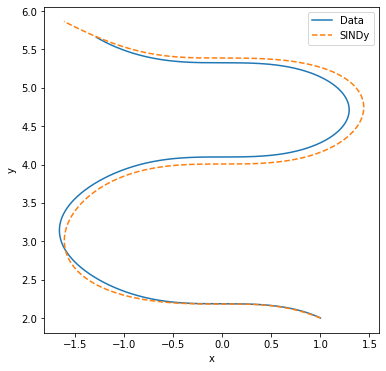

In [4]:
x_model = model.simulate(x[0, :], t)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(x[:, 0], x[:, 1], label='Data')
ax.plot(x_model[:, 0], x_model[:, 1], '--', label='SINDy')
ax.set(xlabel='x', ylabel='y')
ax.legend()
fig.show()

The fit isn't especially good. The trajectory looks like it might be periodic; maybe we will have better luck using trigonometric basis functions.

We can swap out the default polynomial library by forming a new library and passing it into the `SINDy` constructor.

In [5]:
fourier_library = ps.FourierLibrary(n_frequencies=2)

model = ps.SINDy(feature_library=fourier_library, feature_names=['x', 'y'])
model.fit(x, t=t)
model.print()

x' = 1.000 sin(2 y)
y' = -0.408 sin(1 y) + -0.573 cos(1 y) + -0.370 cos(2 x) + -0.342 sin(2 y)


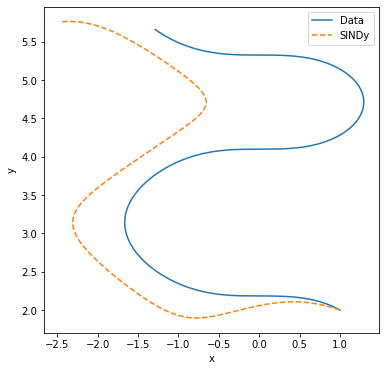

In [6]:
x_model = model.simulate(x[0, :], t)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(x[:, 0], x[:, 1], label='Data')
ax.plot(x_model[:, 0], x_model[:, 1], '--', label='SINDy')
ax.set(xlabel='x', ylabel='y')
ax.legend()
fig.show()

The fit is even worse than before. The large number of terms present in the second equation suggest we may either need to increase the sparsity threshold (to eliminate terms) or that our library is not yet rich enough to capture the dynamics. To fix this we will tweak the parameters of the optimizer, increasing the threshold and adding constant basis functions to the library. We retain the trigonometric/Fourier library functions from before.

In [7]:
optimizer = ps.STLSQ(threshold=0.2, fit_intercept=True)

model = ps.SINDy(
    feature_library=fourier_library,
    optimizer=optimizer,
    feature_names=['x', 'y']
)
model.fit(x, t=t)
model.print()

x' = 1.000 sin(2 y)
y' = -1.000 cos(1 x) + 0.999


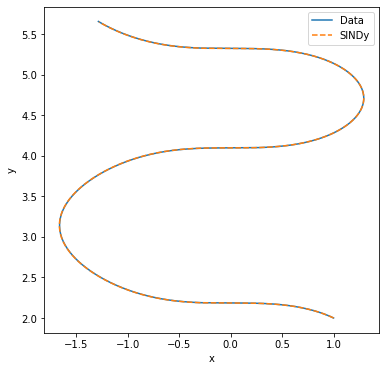

In [8]:
x_model = model.simulate(x[0, :], t)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(x[:, 0], x[:, 1], label='Data')
ax.plot(x_model[:, 0], x_model[:, 1], '--', label='SINDy')
ax.set(xlabel='x', ylabel='y')
ax.legend()
fig.show()

That's much better!

## Advanced features

* Other optimizers (e.g. LASSO or ElasticNet) are easy to add with our wrapper class; SR3 is built-in
* Additional differentiation methods for handling noisy data (or pass in custom methods)
* Customizable candidate function libraries
* Multiple initial conditions
* Discrete time dynamical systems (maps)
* Built-in scoring functions

## Resources
* Code: https://github.com/dynamicslab/pysindy
* Documentation: https://pysindy.readthedocs.io/en/latest/index.html
* PySINDy paper: https://arxiv.org/abs/2004.08424
* SINDy paper: https://www.pnas.org/content/pnas/113/15/3932.full.pdf